## 1. Text Summarization

텍스트 요약은 크게 추출적 요약(extractive summarization)과 추상적 요약(abstractive summarization)으로 나뉩니다.

### 1) 추출적 요약(extractive summarization)

추출적 요약은 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법입니다. 그렇기 때문에 추출적 요약의 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들입니다. 추출적 요약의 대표적인 알고리즘으로 머신 러닝 알고리즘인 텍스트랭크(TextRank)가 있습니다.

단점으로는, 이미 존재하는 문장이나 단어구로만 구성하므로 모델의 언어 표현 능력이 제한된다는 점입니다.

### 2) 추상적 요약(abstractive summarization)

추상적 요약은 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법입니다. 마치 사람이 요약하는 것 같은 방식인데, 추출적 요약보다 난이도가 높습니다.

seq2seq처럼 주로 인공 신경망을 이용하는 방법인데, 단점으로는 인공 신경망들이 기본적으로 지도학습 기반이라는 점입니다. 다시 말해 추상적 요약을 인공 신경망으로 훈련하기 위해서는 '원문'뿐 아니라 '실제 요약문'이라는 레이블 데이터가 있어야합니다. 그렇기 때문에 데이터를 구성하는 것 자체가 하나의 부담입니다.


In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

np.random.seed(seed=0)

In [2]:
data = pd.read_csv('Reviews.csv', nrows=100000)
print(len(data))

100000


In [3]:
data = data[['Text', 'Summary']]

In [4]:
print('Text unique data : ', data['Text'].nunique())
print('Summary unique data : ', data['Summary'].nunique())

Text unique data :  88426
Summary unique data :  72348


In [5]:
data.drop_duplicates(subset=['Text'], inplace=True)
print(len(data))

88426


In [6]:
data.isnull().sum()

Text       0
Summary    1
dtype: int64

In [7]:
data.dropna(axis=0, inplace=True)
print(len(data))

88425


In [8]:
# 전처리 함수 내 사용
contractions = {"'cause": 'because',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "could've": 'could have',
 "couldn't": 'could not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'll": 'he will',
 "he's": 'he is',
 "here's": 'here is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "needn't": 'need not',
 "needn't've": 'need not have',
 "o'clock": 'of the clock',
 "oughtn't": 'ought not',
 "oughtn't've": 'ought not have',
 "sha'n't": 'shall not',
 "shan't": 'shall not',
 "shan't've": 'shall not have',
 "she'd": 'she would',
 "she'd've": 'she would have',
 "she'll": 'she will',
 "she'll've": 'she will have',
 "she's": 'she is',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',
 "so's": 'so as',
 "so've": 'so have',
 "that'd": 'that would',
 "that'd've": 'that would have',
 "that's": 'that is',
 "there'd": 'there would',
 "there'd've": 'there would have',
 "there's": 'there is',
 "they'd": 'they would',
 "they'd've": 'they would have',
 "they'll": 'they will',
 "they'll've": 'they will have',
 "they're": 'they are',
 "they've": 'they have',
 "this's": 'this is',
 "to've": 'to have',
 "wasn't": 'was not',
 "we'd": 'we would',
 "we'd've": 'we would have',
 "we'll": 'we will',
 "we'll've": 'we will have',
 "we're": 'we are',
 "we've": 'we have',
 "weren't": 'were not',
 "what'll": 'what will',
 "what'll've": 'what will have',
 "what're": 'what are',
 "what's": 'what is',
 "what've": 'what have',
 "when's": 'when is',
 "when've": 'when have',
 "where'd": 'where did',
 "where's": 'where is',
 "where've": 'where have',
 "who'll": 'who will',
 "who'll've": 'who will have',
 "who's": 'who is',
 "who've": 'who have',
 "why's": 'why is',
 "why've": 'why have',
 "will've": 'will have',
 "won't": 'will not',
 "won't've": 'will not have',
 "would've": 'would have',
 "wouldn't": 'would not',
 "wouldn't've": 'would not have',
 "y'all": 'you all',
 "y'all'd": 'you all would',
 "y'all'd've": 'you all would have',
 "y'all're": 'you all are',
 "y'all've": 'you all have',
 "you'd": 'you would',
 "you'd've": 'you would have',
 "you'll": 'you will',
 "you'll've": 'you will have',
 "you're": 'you are',
 "you've": 'you have'}

In [9]:
stop_words = set(stopwords.words('english'))
print(len(stop_words))

179


In [10]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, 'lxml').text # remove html tag
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"', '', sentence) # 쌍따옴표 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split()])
    sentence = re.sub(r"'s\b", "", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence) # Normalize 'm'

    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens

In [11]:
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

clean_text[:3]

<ipython-input-10-0edf059a862d>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, 'lxml').text # remove html tag


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch']

In [12]:
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))

clean_summary[:5]

<ipython-input-10-0edf059a862d>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, 'lxml').text # remove html tag
<ipython-input-10-0edf059a862d>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  sentence = BeautifulSoup(sentence, 'lxml').text # remove html tag


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [13]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [14]:
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


In [15]:
data.dropna(axis=0, inplace=True)
print(len(data))

88355


max length of Text : 1235
Min length of Text : 2
Average length of Text : 38.792428272310566

Max length of Summary : 28
Min length of Summary : 1
Average length of Summary : 4.010729443721352


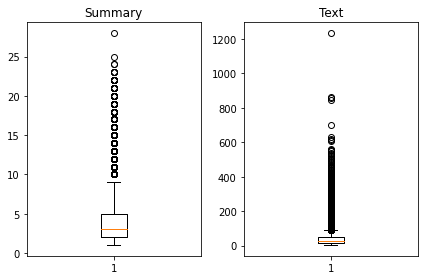

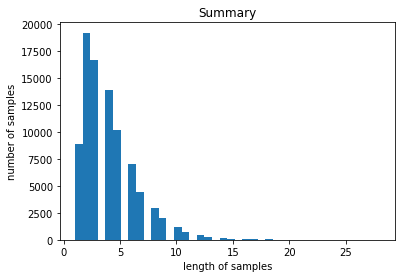

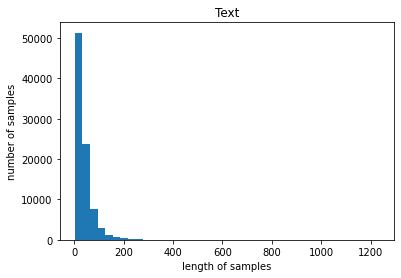

In [16]:
# 길이 분포 확인
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('max length of Text : {}'.format(np.max(text_len)))
print("Min length of Text : {}".format(np.min(text_len)))
print("Average length of Text : {}".format(np.mean(text_len)))
print()
print("Max length of Summary : {}".format(np.max(summary_len)))
print("Min length of Summary : {}".format(np.min(summary_len)))
print("Average length of Summary : {}".format(np.mean(summary_len)))

plt.rcParams['axes.unicode_minus'] = False

plt.subplot(121)
plt.boxplot(summary_len)
plt.title('Summary')

plt.subplot(122)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
text_max_len = 50
summary_max_len = 10

def below_threshold_len(max_len ,nested_list):
    cnt = 0
    for s in nested_list:
        if len(s.split()) <= max_len:
            cnt += 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율 : 0.7745119121724859
전체 샘플 중 길이가 10 이하인 샘플의 비율 : 0.9788580159583499


In [18]:
data = data[data['Text'].apply(lambda x : len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x : len(x.split()) <= summary_max_len)]
print(len(data))

67579


In [19]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [20]:
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken ' + x)
data['decoder_output'] = data['Summary'].apply(lambda x : x + ' endtoken')
data.head()

,Text,Summary,decoder_input,decoder_output
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food endtoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised endtoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all endtoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine endtoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy endtoken


In [21]:
encoder_input = np.array(data['Text'])
decoder_input  = np.array(data['decoder_input'])
decoder_output = np.array(data['decoder_output'])

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[55943 65808 26853 ... 45891 42613 43567]


In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_output = decoder_output[indices]

n_of_val = int(len(encoder_input) * 0.15)
print(n_of_val)

10136


In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_output_train = decoder_output[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_output_test = decoder_output[-n_of_val:]

print(len(encoder_input_train))
print(len(decoder_input_train))
print(len(encoder_input_test))
print(len(decoder_input_test))

57443
57443
10136
10136


In [25]:
src_vocab = 10000
tar_vocab = 10000

src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[0])

[113, 4, 315, 252, 66, 38, 3784, 308, 9, 204, 95, 22, 164, 131, 1058, 146, 303, 5217]


In [26]:
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_output_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_output_train = tar_tokenizer.texts_to_sequences(decoder_output_train)

decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_output_test = tar_tokenizer.texts_to_sequences(decoder_output_test)

print(decoder_input_train[0])

[1, 155, 121]


In [27]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]
print(len(drop_train))
print(len(drop_test))

121
109


In [28]:

encoder_input_test = [encoder_input_test[index] for index in range(len(encoder_input_test)) if not index in drop_test]
decoder_input_test = [decoder_input_test[index] for index in range(len(decoder_input_test)) if not index in drop_test]
decoder_output_test = [decoder_output_test[index] for index in range(len(decoder_output_test)) if not index in drop_test]

print(len(encoder_input_test))
print(len(decoder_input_test))

10027
10027


In [29]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')

decoder_output_train = pad_sequences(decoder_output_train, maxlen=summary_max_len, padding='post')
decoder_output_test = pad_sequences(decoder_output_test, maxlen=summary_max_len, padding='post')

print(encoder_input_train.shape)
print(encoder_input_test.shape)
print(decoder_input_train.shape)
print(decoder_output_train.shape)
print(decoder_input_test.shape)
print(decoder_output_test.shape)

(57443, 50)
(10027, 50)
(57443, 10)
(57443, 10)
(10027, 10)
(10027, 10)


In [30]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



embedding_dim = 128
hidden_size = 256

# Encoder
encoder_inputs = Input(shape=(text_max_len, ))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None, ))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      1280000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [31]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/20.%20Text%20Summarization%20with%20Attention/attention.py",filename="attention.py")

('attention.py', <http.client.HTTPMessage at 0x23ee92907f0>)

In [32]:
from attention import AttentionLayer

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_state = attn_layer([encoder_output3, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      1280000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y=decoder_output_train, validation_data=([encoder_input_test, decoder_input_test], decoder_output_test), batch_size=256, callbacks=[es], epochs=50)


Epoch 1/50
225/225 [==============================] - 237s 1s/step - loss: 2.6492 - val_loss: 2.3120
Epoch 2/50
225/225 [==============================] - 229s 1s/step - loss: 2.3117 - val_loss: 2.1686
Epoch 3/50
225/225 [==============================] - 224s 995ms/step - loss: 2.1990 - val_loss: 2.0783
Epoch 4/50
225/225 [==============================] - 226s 1s/step - loss: 2.1071 - val_loss: 2.0057
Epoch 5/50
225/225 [==============================] - 222s 985ms/step - loss: 2.0328 - val_loss: 1.9458
Epoch 6/50
225/225 [==============================] - 226s 1s/step - loss: 1.9712 - val_loss: 1.9148
Epoch 7/50
225/225 [==============================] - 226s 1s/step - loss: 1.9212 - val_loss: 1.8837
Epoch 8/50
225/225 [==============================] - 226s 1s/step - loss: 1.8770 - val_loss: 1.8818
Epoch 9/50
225/225 [==============================] - 226s 1s/step - loss: 1.8378 - val_loss: 1.8411
Epoch 10/50
225/225 [==============================] - 225s 1s/step - loss: 1.8027 - 

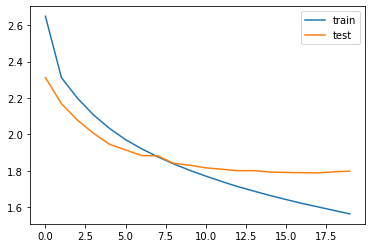

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [35]:
# Model test
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

decoder_state_input_h = Input(shape=(hidden_size, ))
decoder_state_input_c = Input(shape=(hidden_size, ))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [48]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'endtoken':
            decoded_sentence += ' ' + sampled_token
        
        if sampled_token == 'endtoken' or len(decoded_sentence.split()) >= (summary_max_len -1):
            stop_condition=True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c
    return decoded_sentence[1:]

In [49]:
def seq2text(input_seq):
    sentence = ''
    for i in input_seq:
        if i!= 0:
            sentence = sentence + src_index_to_word[i] + ' '
    
    return sentence

def seq2summary(input_seq):
    sentence = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken']) and i != tar_word_to_index['endtoken']:
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence

In [50]:
for i in range(500, 1000):

    print("Original Sentence : ", seq2text(encoder_input_test[i]))
    print("Target Summary : ", seq2summary(decoder_input_test[i]))
    print("Predicted Summary : ", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print('\n')

    if i == 504:
        break


Original Sentence :  love drinking hot tea favorites lots lemon figuring ginger would interesting addition thought would give try drink dissolved completely dark yellow brew ginger flavor way powerful could taste lemon used oz water strong watered nothing diminish ginger fact tea even hot taste chili pass one 
Target Summary :  not for me 
Predicted Summary :  great tea


Original Sentence :  found today gelatin product coming pork know would add gelatin first place dha fish oil fine lady answered phone told dha gerber baby food items pork gelatin infants need gelatin age 
Target Summary :  pork gelatin 
Predicted Summary :  do not waste your money


Original Sentence :  fong chili garlic sauce oz sauce made crushed red peppers garlic world find growing list uses add mexican chinese italian dishes put table dinner guests heat dishes individually like spicey hot dishes love chili garlic sauce 
Target Summary :  superb heat and taste 
Predicted Summary :  not for hot sauce


Original Sen